# Demo: Preprocessing

In [1]:
import autoroot
from typing import Optional, Callable
import toolz 
import functools as ft
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.auto as tqdm

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import astropy
from datetime import timedelta, datetime
from sunpy.map import Map

In [3]:
from helio_tools._src.utils.io import get_list_filenames

base_path = "/home/juanjohn/data/helio/sdo"
ext = ".fits"

data_filenames = get_list_filenames(base_path, ext)
print(len(data_filenames))



2695


## Preprocessing

```python
train_months = list(range(2, 10))
sdo_dataset = AIADataset(sdo_path, wavelength=304, months=train_months)
sdo_dataset = StorageDataset(sdo_dataset,
                             sdo_converted_path,
                             ext_editors=[RandomPatchEditor((256, 256))])


# ======================

class AIADataset(BaseDataset):
    def __init__(self, data, wavelength, resolution=2048, ext='.fits', calibration='auto', **kwargs):
        norm = sdo_norms[wavelength]
        editors = [LoadMapEditor(),
                   NormalizeRadiusEditor(resolution),
                   AIAPrepEditor(calibration=calibration),
                   MapToDataEditor(),
                   NormalizeEditor(norm),
                   ReshapeEditor((1, resolution, resolution))]
        super().__init__(data, editors=editors, ext=ext, **kwargs)
```


In [4]:
from helio_tools._src.editors.load import load_fits_to_map
from helio_tools._src.editors.scale import normalize_radius, normalize_fn
from helio_tools._src.editors.calibration import correct_degregation
from helio_tools._src.editors.datastructure import map_to_ndarray
from astropy.visualization import ImageNormalize, LinearStretch, AsinhStretch
from einops import rearrange
from toolz import compose_left, partial, pipe

### 1. Filter Files for Wavelength

First, we will filter the files for the wavelength `304`. 
We will also only take a demo file for this demonstration.

In [5]:
# filter for wavelength 304
data_filenames_304 = list(filter(lambda k: '304' in k, data_filenames))

# get demo file
demo_file: str = data_filenames_304[0]

### 2. `.fits` file to `Map`

Next, we will load the `.fits` file to a `sunpy.map.Map` object. 
This is a very convenient object to work with because `.fits` files are very unintuitive for the inexperienced. 
So we will use this higher order wrapper instead of dealing directly with `.fits` files.

See the [sunpy.map](https://docs.sunpy.org/en/stable/reference/map.html) docs for more details.

In [6]:
# create function
fn1: Callable[[Map, ...], Map] = load_fits_to_map

# apply function
out: Map = load_fits_to_map(demo_file)

We can directly plot the image along with the distribution of pixels and the associated meta-data.

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2022-03-01 00:00:05
Exposure Time,2.902031 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600165 0.600165] arcsec / pix
Reference Pixel,[2070.345947 2007.299683] pix

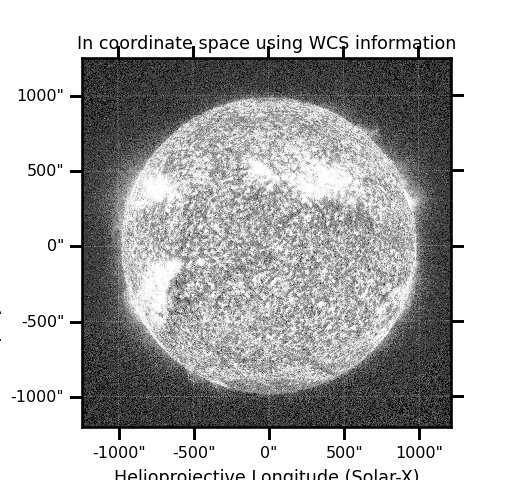
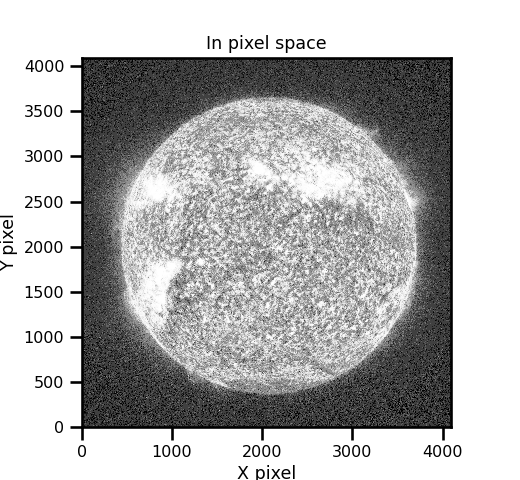
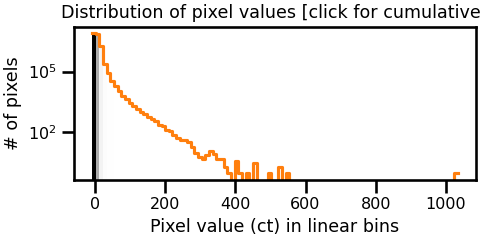
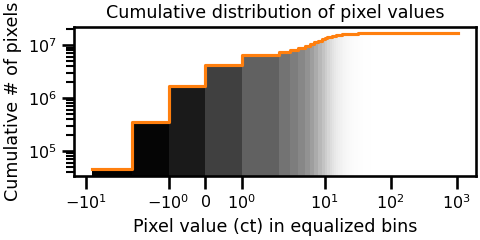

In [7]:
out

### 3. Normalized Radius

Next, we will normalized the radius by some resolution. 
We also have the option to crop the edge bits that we don't want within the image.

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2022-03-01 00:00:05
Exposure Time,2.902031 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.04059295 1.04059295] arcsec / pix
Reference Pixel,[1023.5 1023.5] pix

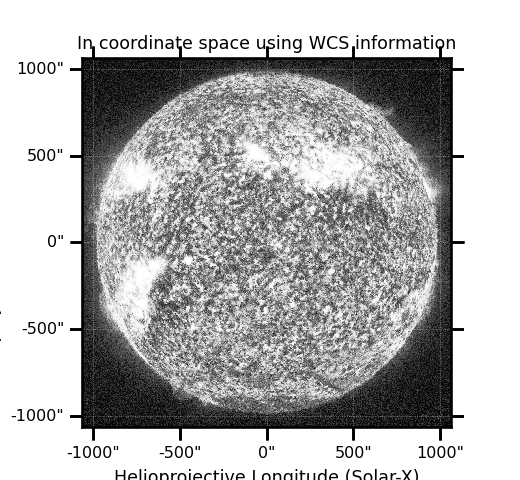
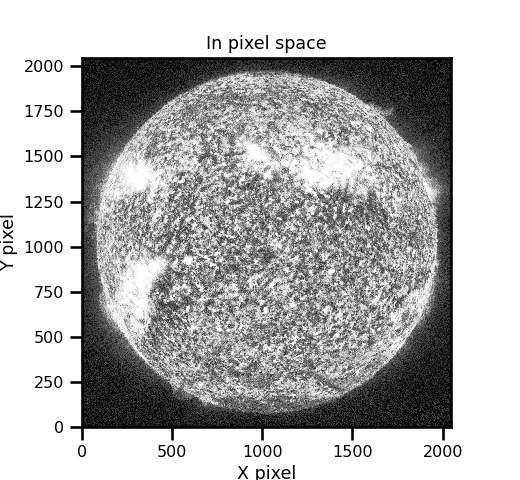
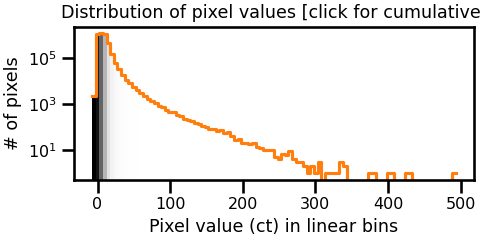
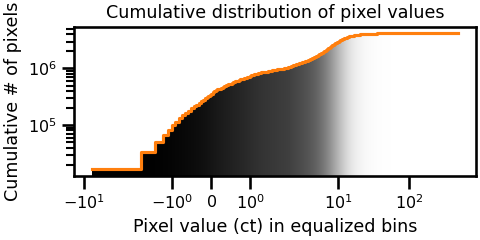

In [8]:
# define parameters
resolution = 2048
crop = True
padding_factor = 0.1

# define function
fn2: Callable[[Map, ...], Map] = partial(normalize_radius, resolution=resolution, padding_factor=padding_factor, crop=crop)

# apply function
out: Map = fn2(out)

# plot output
out

### 3. Correct Degregation

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2022-03-01 00:00:05
Exposure Time,2.902031 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.04059295 1.04059295] arcsec / pix
Reference Pixel,[1023.5 1023.5] pix

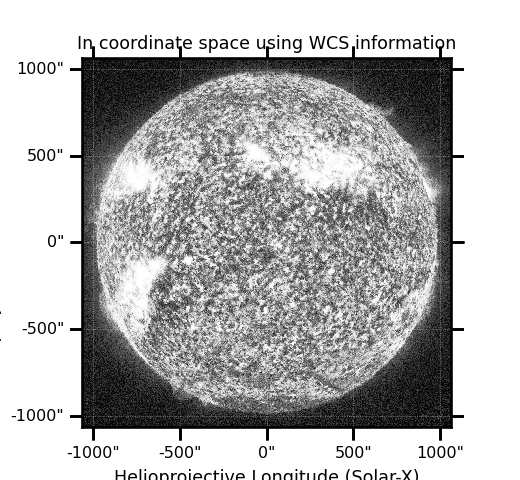
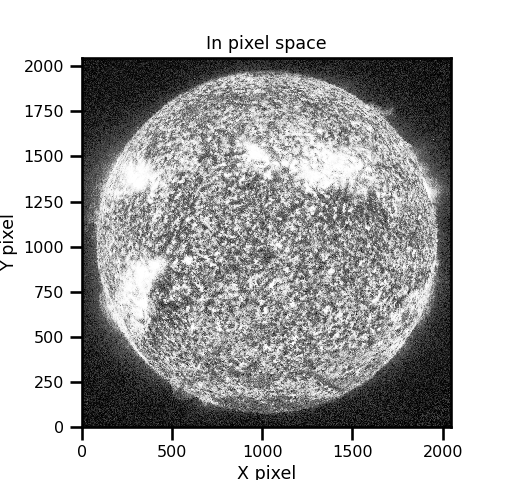
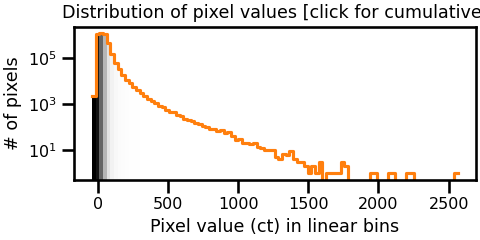
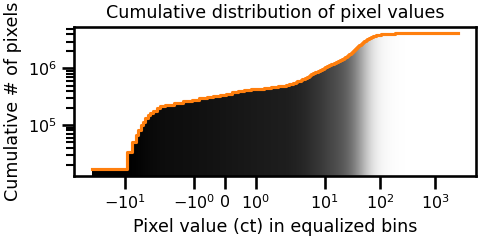

In [9]:
# define parameters
method = "auto"

# define function
fn3: Callable[[Map, ...], Map]  = partial(correct_degregation, method=method)

# apply function
out: Map = fn3(out)

# plot output
out

### 4. Change to Numpy.ndarray

Now, we will change the data structure to a numpy.ndarray.
This is more convenient for some functionality, e.g., normalization. 
However, it is completely optional

In [10]:
# define function
fn4: Callable[[Map, ...], np.ndarray]   = map_to_ndarray

# apply function
out: np.ndarray = fn4(out)

Of course now, we don't have the same plotting capabilities so we need to plot things from scratch using matplotlib.

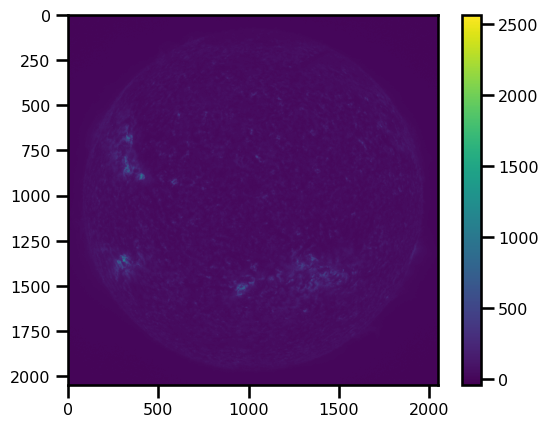

In [11]:
# plot function
fig, ax = plt.subplots()

pts = ax.imshow(out)
fig.colorbar(pts)

plt.show()

### 5. Normalization

We immediately notice that the image is not really clear about the quantities within. 
So we need to do some sort of normalization. 
In this case, we will use some predefined normalization schemes found [here](https://github.com/spaceml-org/MDRAIT_ITI/blob/master/iti/data/editor.py#L60). 
We will define it here manually for more clarity.

In [12]:
# define normalization parameters
a = 0.001
stretch = AsinhStretch(a=a)
vmin, vmax = 0, 8_800
clip = True
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch, clip=clip)

# define function
fn5: Callable[[np.ndarray, ...], np.ndarray] = partial(normalize_fn, fn=norm)

# apply function
out: np.ndarray = fn5(out)

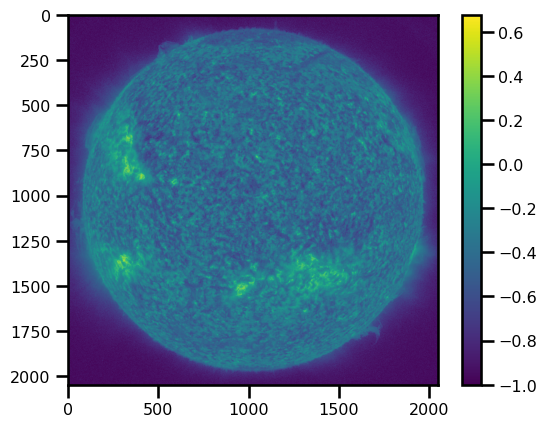

In [13]:
# plot function
fig, ax = plt.subplots()

pts = ax.imshow(out)
fig.colorbar(pts)

plt.show()

This image is much clearer and we can see some distinct featureswithin the image.

### 6. Channel Dimension

We would like to save our new image to be "ML-Ready". 
However, we need to save it in an image-like format.
We are using the `numpy` convention so we'll save it as: 

`Height x Width x Channel`

In [14]:
# define parameters
pattern: str = 'H W -> H W 1'
H = W = resolution

# define function
fn6: Callable[[np.ndarray, ...], np.ndarray]  = lambda x: rearrange(x, pattern=pattern, H=H, W=W)

# apply function
out: np.ndarray = fn6(out)

assert out.shape == (resolution, resolution, 1)

In [15]:
out.shape

(2048, 2048, 1)

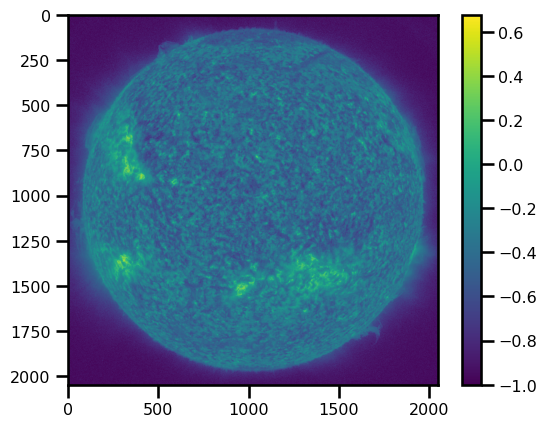

In [16]:
# plot function
fig, ax = plt.subplots()

pts = ax.imshow(out)
fig.colorbar(pts)

plt.show()

## Stacking Transforms

It's a bit cumbersome to type all of the functions out.
Now, we will stack together some transformations to make a *pipeline*. 

In [17]:
# create composition function
fn: Callable[[str], np.ndarray] = compose_left(fn1, fn2, fn3, fn4, fn5, fn6)

# pipe demo file through transformations
out_: np.ndarray = fn(demo_file)

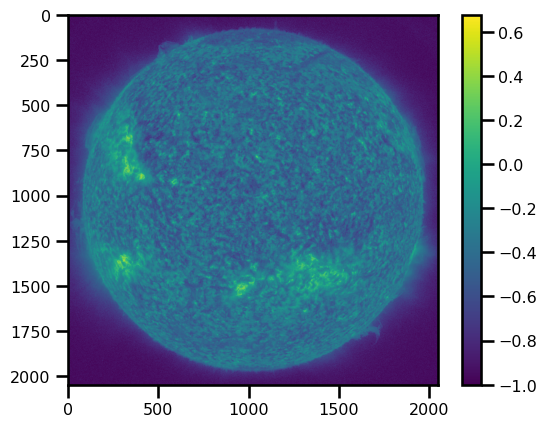

In [18]:
# plot function
fig, ax = plt.subplots()

pts = ax.imshow(out_[...,0])
fig.colorbar(pts)

plt.show()

We can check to make sure that the array is equation.

In [19]:
np.testing.assert_array_almost_equal(out, out_)

## ML-Ready Data

Now, we want to apply these functions over all of the files within the dataset.
We will save it in two different file formats

In [20]:
from pathlib import Path

In [21]:
save_base_path = Path("/home/juanjohn/data/helio/sdo_npy/304")
save_base_path.mkdir(parents=True, exist_ok=True)

In [22]:
for ifile in tqdm.tqdm(data_filenames_304[:5]):
    
    # transform file
    out = fn(ifile)

    # grab stem save
    ifile_stem = Path(ifile).stem

    # save name
    save_path = save_base_path.joinpath(ifile_stem + ".npy")

    # 
    np.save(save_path, out)
    

  0%|          | 0/5 [00:00<?, ?it/s]

### Parallelization

The above section is an embarassingly parallel operation.
In other words, we can use multiple processes to parallize this operation.
Without doing too much work, we'll use the `joblib` to parallize the operations.

In [23]:
from joblib import Parallel, delayed

First, we'll wrap the entire operation

In [24]:
def parallel_step(ifile):

    # transform file
    out = fn(ifile)

    # grab stem save
    ifile_stem = Path(ifile).stem

    # save name
    save_path = save_base_path.joinpath(ifile_stem + ".npy")

    # save to `.npy` file
    np.save(save_path, out)
    

In [26]:
n_jobs = 4
verbose = 3
results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(parallel_step)(ifile) for ifile in data_filenames_304[:50]
    )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   42.8s finished


In [41]:
parent_path = Path(save_path).parent
!du -h $parent_path

17G	/home/juanjohn/data/helio/sdo_npy/304


### Saving Images

In [42]:

save_base_path = Path("/home/juanjohn/data/helio/sdo_png/304")
save_base_path.mkdir(parents=True, exist_ok=True)

In [43]:
# from skimage.io import imsave
from imageio import imsave

In [44]:
for ifile in tqdm.tqdm(data_filenames_304[:10]):
    
    # transform file
    out = fn(ifile)

    # grab stem save
    ifile_stem = Path(ifile).stem

    # save name
    save_path = save_base_path.joinpath(ifile_stem + ".png")

    # save to `.npy` file
    imsave(save_path, (255 * out).squeeze().astype(np.uint8), )
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
def parallel_step(ifile):

    # transform file
    out = fn(ifile)

    # grab stem save
    ifile_stem = Path(ifile).stem

    # save name
    save_path = save_base_path.joinpath(ifile_stem + ".png")

    # save to `.npy` file
    imsave(save_path, (255 * out).squeeze().astype(np.uint8), )

In [48]:
n_jobs = 4
verbose = 3
results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(parallel_step)(ifile) for ifile in data_filenames_304[:50]
    )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   38.8s finished


In [49]:
parent_path = Path(save_path).parent
!du -h $parent_path

169M	/home/juanjohn/data/helio/sdo_png/304
